In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [17]:
!pip install pydrive                             # Package to use Google Drive API - not installed in Colab VM by default
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth                    # Other necessary packages
from oauth2client.client import GoogleCredentials
auth.authenticate_user()                         # Follow prompt in the authorization process
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
your_module = drive.CreateFile({"id": "176fVmFMju81nPM2jsNOADdU5YnEA6Cl7"})   # "your_module_file_id" is the part after "id=" in the shareable link
your_module.GetContentFile("dlc_practical_prologue.py")          # Save the .py module file to Colab VM
import dlc_practical_prologue as prologue

In [18]:
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [0]:
train_input_first_approach =  torch.zeros(size = (1000,392))
test_input_first_approach = torch.zeros(size = (1000,392))

for i in range(train_input.size(0)):
    #print(torch.cat((train_input[i,0],train_input[i,1]),0).size())
    train_input_first_approach[i]  = torch.cat((torch.flatten(train_input[i,0]),torch.flatten(train_input[i,1])),0)
    test_input_first_approach[i] = torch.cat((torch.flatten(test_input[i,0]),torch.flatten(test_input[i,1])),0)
    


In [21]:
import torch
import torch.nn.functional as F
from torch import nn,optim

# define the network class
class MyNetwork(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(392, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 1)
        self.fc4 = nn.Linear(100, 20)
        
    def forward(self, x):
        # define forward pass
        x = F.relu(self.fc1(x))
        y = F.relu(self.fc4(x))
        x = F.relu(self.fc2(x))
        y = y.view(-1,2,10)
        x = torch.sigmoid(self.fc3(x))
        
        return x,y

# instantiate the model
model = MyNetwork()

# print model architecture
print(model)



MyNetwork(
  (fc1): Linear(in_features=392, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
  (fc4): Linear(in_features=100, out_features=20, bias=True)
)


In [22]:
import torch
import torch.nn.functional as F
from torch import nn,optim

# define the network class
class MyNetworkv2(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(392, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 1)
       
        
    def forward(self, x):
        # define forward pass
        x = F.relu(self.fc1(x))
        y = F.relu(self.fc2(x))
        x = F.relu(self.fc2(x))
        y = y.view(-1,2,10)
        x = torch.sigmoid(self.fc3(x))
        
        return x,y

# instantiate the model
model = MyNetwork()

# print model architecture
print(model)

MyNetwork(
  (fc1): Linear(in_features=392, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
  (fc4): Linear(in_features=100, out_features=20, bias=True)
)


In [0]:

def training_model(train_input, train_target, model, batch, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    criterion = nn.BCELoss()
    total_loss = 0
    
    for b in range(0, train_input.size(0), batch):
        output, aux = model(train_input.narrow(0, b, batch))            
        loss = criterion(output, train_target.narrow(0, b, batch))
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

In [0]:
def compute_nb_errors(model, data_input, data_target, batch):
    
    nb_data_errors = 0

    for b in range(0, data_input.size(0), batch):
        output, _ = model(data_input.narrow(0, b, batch))
        
        predicted_classes = (output>0.5).float()
        
        for k in range(batch):
            if data_target[b + k].item() != predicted_classes[k,0].item():
                nb_data_errors = nb_data_errors + 1
    return nb_data_errors

In [0]:

from itertools import accumulate

def precision_recall(target, pred):
  
  target = [True if x else False for x in target]
  sorted_ind = sorted(range(len(list(pred))), key=lambda k: list(pred)[k])
  sorted_ind.reverse()
  #print(sorted_ind)
  pred = [pred[i] for i in sorted_ind]
  #print(pred)
  target = [target[i] for i in sorted_ind]
  #print(target)
  uniqs = list(set(list(pred)))
  uniqs.sort(reverse=True)
  
  indexes = [list(pred).index(x) for x in uniqs]
  
  #print(indexes)
  t = [1 if x else 0 for x in target]
  tp_accum = list(accumulate(t))
  
  
  tps = [tp_accum[i] for i in indexes]
  #print(tps)
  ones = [1]*(len(target))
  fp_accum = list(accumulate([a_i - b_i for a_i, b_i in zip(ones, t)]))
  fps = [1+t-tp for t,tp in zip(indexes,tps)]
  #print(fps)
  
  precision = [x/(x + y) if x+y else 0 for x,y in zip(tps,fps)]
  recall =  [x/tps[-1] if tps[-1] else 0 for x in tps]

  thresholds = [pred[i] for i in indexes]
  
  last_ind = len(tps)-2
  sl = slice(last_ind, None, -1)
  
  #print(precision[sl],precision)
  pre = precision[sl]
  pre.append(1.0)
  rec = recall[sl]
  rec.append(0.0)
  return pre, rec, thresholds[sl]


In [0]:

def roc_true(target, pred):
  
  target = [True if x else False for x in target]
  sorted_ind = sorted(range(len(list(pred))), key=lambda k: list(pred)[k])
  sorted_ind.reverse()
 
  pred = [pred[i] for i in sorted_ind]

  target = [target[i] for i in sorted_ind]

  uniqs = list(set(list(pred)))
  uniqs.sort(reverse=True)
  
  indexes = [list(pred).index(x) for x in uniqs]
  

  t = [1 if x else 0 for x in target]
  tp_accum = list(accumulate(t))
  
  
  tps = [tp_accum[i] for i in indexes]

  ones = [1]*(len(target))
  fp_accum = list(accumulate([a_i - b_i for a_i, b_i in zip(ones, t)]))
  fps = [1+t-tp for t,tp in zip(indexes,tps)]

  thresholds = [pred[i] for i in indexes]

  thresholds.insert(0, thresholds[0] + 1)
  tps.insert(0, 0)
  fps.insert(0, 0)
  fpr = [i/fps[-1] for i in fps]
  tpr = [i/tps[-1] for i in tps]

  return fpr, tpr, thresholds


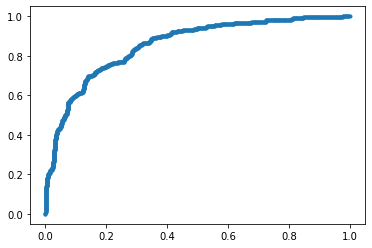

In [39]:
from matplotlib import pyplot

pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


loss 15.77613228559494
386   412
loss 8.1650630235672
323   358
loss 6.755587041378021
284   335
loss 6.020022094249725
265   314
loss 5.52670031785965
252   308
loss 5.155505150556564
233   298
loss 4.839887708425522
222   288
loss 4.572867006063461
205   288
loss 4.3571290373802185
196   279
loss 4.1552830040454865
192   274
loss 3.9825928807258606
180   275
loss 3.8266060948371887
173   271
loss 3.6737100481987
166   273
loss 3.5357086062431335
156   272
loss 3.409719228744507
148   269
loss 3.2933084666728973
140   263
loss 3.1778486371040344
136   263
loss 3.0724257826805115
123   262
loss 2.972702369093895
118   257
loss 2.8777416944503784
113   257
loss 2.7844851166009903
103   255
loss 2.700074478983879
100   253
loss 2.6173225492239
98   250
loss 2.5395707339048386
94   248
loss 2.470893308520317
91   248
loss 2.39329931139946
85   248
loss 2.3258188664913177
87   244
loss 2.257540315389633
80   249
loss 2.193214252591133
76   249
loss 2.129390150308609
76   246
loss 2.0693101

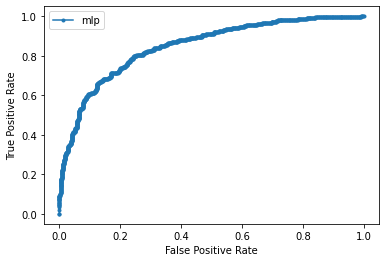

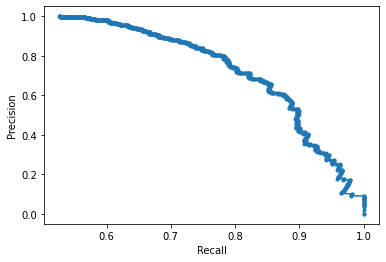

In [40]:
epochs = 170
losses = torch.zeros((3, epochs))
model = MyNetwork()
for e in range(epochs):
    print("loss", training_model(train_input_first_approach, train_target.float(), model , 100, 0.001))
    print(compute_nb_errors(model, train_input_first_approach,train_target, 100), " ",compute_nb_errors(model, test_input_first_approach,test_target, 100))
    
  
    if e == 160:
      output, _ = model(test_input_first_approach)
      fpr, tpr, _  = (roc_true(test_target.tolist(),torch.flatten(output).tolist()))
      pyplot.plot(fpr, tpr, marker='.', label='mlp')
      pyplot.xlabel('False Positive Rate')
      pyplot.ylabel('True Positive Rate')
      # show the legend
      pyplot.legend()
      # show the plot
      pyplot.show()

      lr_recall, lr_precision, _  = (precision_recall(test_target.tolist(),torch.flatten(output).tolist()))
      pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
      # axis labels
      pyplot.xlabel('Recall')
      pyplot.ylabel('Precision')
      break
    

In [0]:
def training_aux(train_input, train_target, train_classes, model, batch, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    Binary_Criterion = nn.BCELoss()
    Aux_Criterion = nn.CrossEntropyLoss()
    total_loss_aux = 0
    total_loss_bin = 0
    final_total_loss = 0
    for b in range(0, train_input.size(0), batch):
        output, aux = model(train_input.narrow(0, b, batch))
        target_classes = train_classes.narrow(0, b, batch)
        target_comparison = train_target.narrow(0, b, batch)
        aux_loss = Aux_Criterion(aux[:,0], target_classes[:,0]) + Aux_Criterion(aux[:,0], target_classes[:,1])
        binary_loss = Binary_Criterion(output, target_comparison)
        final_loss = 0.9*binary_loss + 0.1*aux_loss
        model.zero_grad()
        final_loss.backward()
        optimizer.step()
        total_loss_aux += aux_loss
        total_loss_bin += binary_loss
        final_total_loss += final_loss
    return final_total_loss, total_loss_aux, total_loss_bin

In [0]:
def compute_nb_errors_aux(model, data_input, data_target, batch):
    
    nb_data_errors = 0

    for b in range(0, data_input.size(0), batch):
        output, _ = model(data_input.narrow(0, b, batch))
        predicted_classes = (output>0.5).float()
        for k in range(batch):
            if data_target[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1
    return nb_data_errors

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


loss 20.676843643188477
418   430
loss 8.914483070373535
342   361
loss 7.206216335296631
304   332
loss 6.33477783203125
284   311
loss 5.766745567321777
258   295
loss 5.353263854980469
233   285
loss 5.032634735107422
216   279
loss 4.776886463165283
211   276
loss 4.560518741607666
195   274
loss 4.372141361236572
188   276
loss 4.209378242492676
172   272
loss 4.059519290924072
164   271
loss 3.9259450435638428
158   267
loss 3.806077241897583
154   263
loss 3.697381019592285
145   264
loss 3.5939369201660156
138   262
loss 3.497607707977295
133   261
loss 3.4057605266571045
126   260
loss 3.317837715148926
124   262
loss 3.2341973781585693
119   265
loss 3.1541223526000977
116   262
loss 3.076148509979248
111   261
loss 3.002424478530884
110   259
loss 2.929628849029541
108   257
loss 2.858781099319458
109   255
loss 2.792747974395752
104   255
loss 2.725344181060791
102   253
loss 2.66202974319458
97   253
loss 2.6002893447875977
96   253
loss 2.5376174449920654
95   255
loss 2.

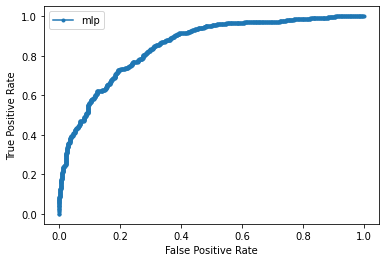

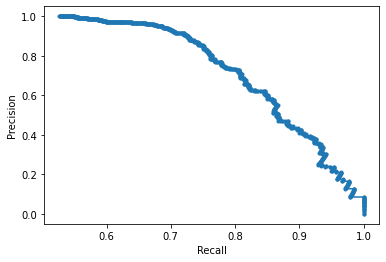

In [45]:
epochs = 160
losses = torch.zeros((3, epochs))
model2 = MyNetwork()
for e in range(epochs):
    print("loss",training_aux(train_input_first_approach, train_target.float(), train_classes, model2 , 100, 0.001)[2].item())
    print(compute_nb_errors_aux(model2, train_input_first_approach,train_target, 100), " ",compute_nb_errors_aux(model2, test_input_first_approach,test_target, 100))
    if e == 150:
      output, _ = model2(test_input_first_approach)
      fpr, tpr, _  = (roc_true(test_target.tolist(),torch.flatten(output).tolist()))
      pyplot.plot(fpr, tpr, marker='.', label='mlp')
      pyplot.xlabel('False Positive Rate')
      pyplot.ylabel('True Positive Rate')
      # show the legend
      pyplot.legend()
      # show the plot
      pyplot.show()

      lr_recall, lr_precision, _  = (precision_recall(test_target.tolist(),torch.flatten(output).tolist()))
      pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
      # axis labels
      pyplot.xlabel('Recall')
      pyplot.ylabel('Precision')
      break

In [0]:
from torchvision.models.resnet import ResNet, BasicBlock
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=2)
        self.conv1 = torch.nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(super(MnistResNet, self).forward(x), dim=-1)

In [0]:
import torch.nn.functional as nnf
train_input_first_approach_t = nnf.interpolate(train_input, size=(224, 224), mode='bilinear', align_corners=False)
test_input_first_approach_t = nnf.interpolate(test_input, size=(224, 224), mode='bilinear', align_corners=False)

In [0]:
plt.imshow(train_input_first_approach_t[3,0], cmap="gray")
plt.show()

In [0]:
def training_model_resnet(train_input, train_target, model, batch, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    
    for b in range(0, train_input.size(0), batch):
        inputs , targets = train_input.narrow(0, b, batch).to(device), train_target.narrow(0, b, batch).to(device)
        output = model(inputs)            
        #print("here", output)
        loss = criterion(output, targets)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss
def compute_nb_errors_resnet(model, data_input, data_target, batch):
    
    nb_data_errors = 0

    for b in range(0, data_input.size(0), batch):
        inputs  = data_input.narrow(0, b, batch).to(device)
        output = model(inputs)
        #print(output)
        predicted_classes = torch.max(output, 1)
        #print(predicted_classes)
        for k in range(batch):
            if data_target[b + k].item() != predicted_classes[1][k].item():
                nb_data_errors = nb_data_errors + 1
    return nb_data_errors


In [0]:
epochs = 22
losses = torch.zeros((3, epochs))
model3 = MnistResNet()
model3.to(device)
print(train_input_first_approach_t.size())
for e in range(epochs):
    print("loss", training_model_resnet(train_input_first_approach_t, train_target, model3 , 100, 0.05))
    print(compute_nb_errors_resnet(model3, train_input_first_approach_t,train_target, 100), " ",compute_nb_errors_resnet(model3, test_input_first_approach_t,test_target, 100))